In [108]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.lines import Line2D

from pyopenms import *

In [43]:
def experiment_iter(method, sample = None, penalty = None):
    if sample is None:
        sample = ["UWPROFL0360", "UWPROFL0361", "UWPROFL0362", "UWPROFL0363", "UWPROFL0364"]
    if penalty is None:
        penalty = ["1e5", "3e5", "1e6", "3e6", 
                   "1e7", "3e7", "1e8", "3e8", 
                   "1e9", "3e9", "1e10", "3e10",
                   "1e11", "3e11", "1e12", "3e12", 
                   "1e13", "3e13"]
        
    for s in sample:
        for p in penalty:
            yield s + "_" + method + "_" + p
        
    
def sgl_iter(l1_penalty, sample = None, l2_penalty = None):
    if sample is None:
        sample = ["UWPROFL0360", "UWPROFL0361", "UWPROFL0362", "UWPROFL0363", "UWPROFL0364"]
    if l2_penalty is None:
        l2_penalty = ["1e8", "3e8", "1e9", "3e9", "1e10", "3e10", "1e11", "3e11"]
        
    for s in sample:
        for p in l2_penalty:
            yield s + "_" + "sglasso" + "_" + p + "_" + l1_penalty  

    
def get_experiment(experiment):
    try:
        peptides = pd.read_csv("../Results/" + experiment + "_peptide_hits", 
                               header=-1, sep="\t")
        peptides.columns = ["index", "target", "peptide", "matching", "penalized", "debiased"]
        decoys = pd.read_csv("../Results/" + experiment + "_decoy_hits", 
                             header=-1, sep="\t")
        decoys.columns = ["index", "target", "peptide", "matching", "penalized"]
        return peptides, decoys
    
    except:
        peptides = pd.DataFrame(columns=["index", "target", "peptide", "matching", "penalized", "debiased"])
        decoys = pd.DataFrame(columns=["index", "target", "peptide", "matching", "penalized"])
        return peptides, decoys
    
def value_filter(data, quant):
    select = data["penalized"] > np.quantile(data["penalized"], quant)
    return data[select]

In [44]:
def matching_peaks_wa(data):
    data = data.copy()
    data["matching"] *= data["penalized"]
    sums = data.groupby("peptide")["matching"].sum()
    return sums / data.groupby("peptide")["penalized"].sum()

def fsr_cutoff(peptides, decoys, cutoff=0.01):
    pep_counts = matching_peaks_wa(peptides)
    decoy_counts = matching_peaks_wa(decoys)
    
    def optim(thresh):
        true_hits = np.sum(pep_counts >= thresh)
        false_hits = np.sum(decoy_counts >= thresh)
        fdr = false_hits/(true_hits + false_hits)
        return (cutoff - fdr)**2
    
    top_thresholds = np.random.uniform(0, 10, size = 3)
    for i in np.arange(-3, 2)[::-1]:
        sd = np.power(10., i)
        suggestions = sd * np.random.randn(10, 3) + top_thresholds
        scores = np.array([optim(t) for t in suggestions.flatten()])
        best_args = np.argsort(scores)[:3]
        top_thresholds = suggestions.flatten()[best_args]
    
    best_thresh = np.min(top_thresholds)
    return pep_counts[pep_counts >= best_thresh], decoy_counts[decoy_counts >= best_thresh]

### Counting the occurence of SILAC pairs in each sample

In [45]:
def get_counts(exp):
    peptides, decoys = get_experiment(exp)
    heavy_counts = 0
    light_counts = 0
    if peptides.shape[0] > 0:
        peptides, decoys = value_filter(peptides, 0.5), value_filter(decoys, 0.5)
        selected_peptides, selected_decoys = fsr_cutoff(peptides, decoys)
        re_results = selected_peptides.index.str.contains("136")
        heavy_counts = np.sum(re_results)
        light_counts = np.sum(~re_results)
        
    return heavy_counts, light_counts

In [92]:
lasso_range = ['1e7', '3e7', '1e8', '3e8', '1e9', '3e9', '1e10']
lasso_heavy = []
lasso_light = []
sample = []
pen = []
for exp in experiment_iter("lasso", penalty=lasso_range):
    heavy_counts, light_counts = get_counts(exp)
    total = heavy_counts + light_counts
    if total == 0:
        continue
    lasso_heavy.append(heavy_counts/total)
    lasso_light.append(light_counts/total)
    sample.append(exp.split("_")[0])
    pen.append(exp.split("_")[-1])
lasso_data = pd.DataFrame({"sample": sample*2, "pen": pen*2,
                           "silac": ["heavy"]*len(lasso_heavy) + ["light"]*len(lasso_light),
                           "vals": lasso_heavy + lasso_light})

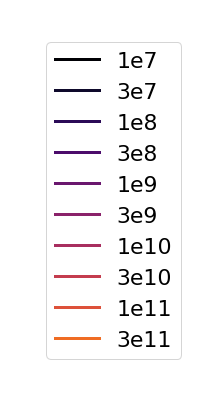

In [138]:
cmap = matplotlib.cm.get_cmap('inferno')
penalty_vals = ["1e7", "3e7", "1e8", "3e8", "1e9", "3e9", "1e10", "3e10", "1e11", "3e11"]
intensity = .0
intensity_map = {}
for p in penalty_vals:
    intensity_map[p] = intensity
    intensity += .075
    
custom_lines = [Line2D([0], [0], color=cmap(intensity_map[p]), lw=3, label = p) for p in penalty_vals]
plt.figure(figsize = (3, 7))
plt.legend(handles=custom_lines, loc='center', prop={'size': 22})
plt.axis('off')
plt.show()

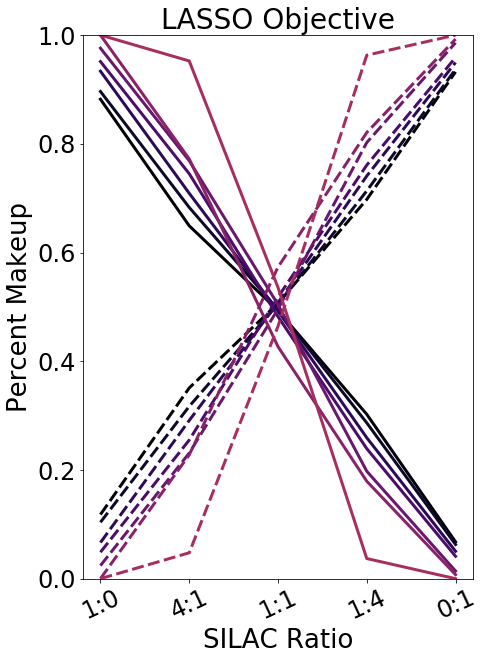

In [140]:
plt.figure(figsize=(7, 10))
for p in lasso_range:
    sns.lineplot(x = "sample", y = "vals", style="silac", lw = 3, color = cmap(intensity_map[p]),
                 data=lasso_data[lasso_data.pen == p], legend=None)
    map_val +=.1
plt.tick_params(labelsize=24)
plt.xticks(np.arange(5), labels = ["1:0", "4:1", "1:1", "1:4", "0:1"], rotation=25)
plt.xlabel("SILAC Ratio", size = 26)
plt.ylabel("Percent Makeup", size = 26)
plt.ylim(0, 1)
plt.title("LASSO Objective", size = 28)
plt.show()

In [95]:
glasso_range = ['1e9', '3e9', '1e10', '3e10', '1e11', '3e11']
glasso_heavy = []
glasso_light = []
sample = []
pen = []
for exp in experiment_iter("glasso",  penalty=glasso_range):
    heavy_counts, light_counts = get_counts(exp)
    total = heavy_counts + light_counts
    if total == 0:
        continue
    glasso_heavy.append(heavy_counts/total)
    glasso_light.append(light_counts/total)
    sample.append(exp.split("_")[0])
    pen.append(exp.split("_")[-1])
glasso_data = pd.DataFrame({"sample": sample*2, "pen": pen*2,
                            "silac": ["heavy"]*len(glasso_heavy) + ["light"]*len(glasso_light),
                            "vals": glasso_heavy + glasso_light})

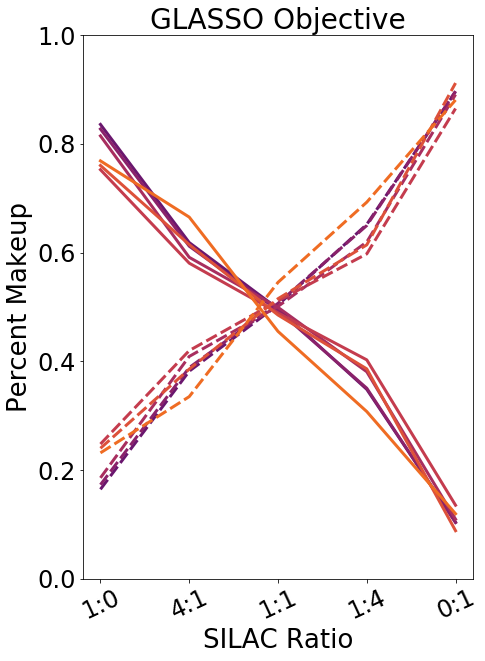

In [141]:
plt.figure(figsize=(7, 10))
cmap = matplotlib.cm.get_cmap('inferno')
map_val = .2
for p in glasso_range:
    rgba = cmap(map_val)
    sns.lineplot(x = "sample", y = "vals", style="silac", lw = 3, color = cmap(intensity_map[p]),
                 data=glasso_data[glasso_data.pen == p], legend=None)
    map_val +=.1
plt.tick_params(labelsize=24)
plt.xticks(np.arange(5), labels = ["1:0", "4:1", "1:1", "1:4", "0:1"], rotation=25)
plt.xlabel("SILAC Ratio", size = 26)
plt.ylabel("Percent Makeup", size = 26)
plt.ylim(0, 1)
plt.title("GLASSO Objective", size = 28)
plt.show()

In [111]:
sglasso_range = ["1e8", "3e8", "1e9", "3e9", "1e10", "3e10", "1e11"]
sglasso_heavy = []
sglasso_light = []
sample = []
pen = []
for exp in sgl_iter("1e9", l2_penalty = sglasso_range):
    heavy_counts, light_counts = get_counts(exp)
    total = heavy_counts + light_counts
    if total == 0:
        continue
    sglasso_heavy.append(heavy_counts/total)
    sglasso_light.append(light_counts/total)
    sample.append(exp.split("_")[0])
    pen.append(exp.split("_")[-2])
sglasso_data = pd.DataFrame({"sample": sample*2, "pen": pen*2,
                             "silac": ["heavy"]*len(sglasso_heavy) + ["light"]*len(sglasso_light),
                             "vals": sglasso_heavy + sglasso_light})

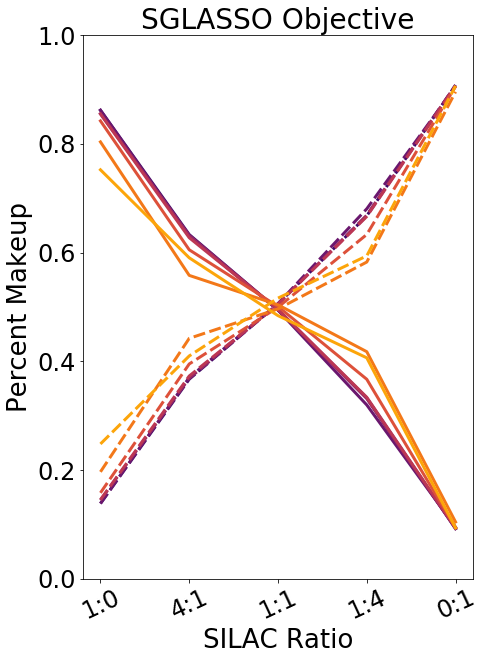

In [142]:
plt.figure(figsize=(7, 10))
cmap = matplotlib.cm.get_cmap('inferno')
map_val = .2
for p in sglasso_range:
    rgba = cmap(map_val)
    sns.lineplot(x = "sample", y = "vals", style="silac", lw = 3, color = rgba,
                 data=sglasso_data[sglasso_data.pen == p], legend=None)
    map_val +=.1
plt.tick_params(labelsize=24)
plt.xticks(np.arange(5), labels = ["1:0", "4:1", "1:1", "1:4", "0:1"], rotation=25)
plt.xlabel("SILAC Ratio", size = 26)
plt.ylabel("Percent Makeup", size = 26)
plt.ylim(0, 1)
plt.title("SGLASSO Objective", size = 28)
plt.show()